In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import FTTransformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-03-31 10:31:25.496971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

2024-03-31 10:31:25.926663: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_19695/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_19695/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Linear Numerical Embedding FT-Transformer

In [15]:
# Explanations need to be set to false until the following bug is fixed: https://github.com/keras-team/keras/issues/19303
EXPLANATIONS = False 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

In [16]:
model = FTTransformer(
    out_dim=1,
    out_activation='sigmoid',
    feature_unique_counts=feature_unique_counts,
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    seq_length=seq_length,
    numerical_embedding_type='linear',
    explainable=EXPLANATIONS    
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.AUC(name="PR AUC", curve='PR')]
# Explanations need to be reworked once the bug is fixed
# if EXPLANATIONS:
#     loss_dict.update({"importances": None})
#     metrics_dict.update({"importances": None})
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [17]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - PR AUC: 0.4353 - loss: 0.5337

2024-03-31 10:31:36.426288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - PR AUC: 0.4652 - loss: 0.5203

2024-03-31 10:31:44.523175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - PR AUC: 0.4700 - loss: 0.5179 - val_PR AUC: 0.6770 - val_loss: 0.3908
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.6965 - loss: 0.3832 - val_PR AUC: 0.6751 - val_loss: 0.3663
Epoch 3/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - PR AUC: 0.7038 - loss: 0.3795

2024-03-31 10:31:47.308532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:47.353733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.6971 - loss: 0.3606 - val_PR AUC: 0.7211 - val_loss: 0.3530
Epoch 4/10


2024-03-31 10:31:47.723942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:47.770055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7237 - loss: 0.3493 - val_PR AUC: 0.7230 - val_loss: 0.3456
Epoch 5/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - PR AUC: 0.7350 - loss: 0.3403

2024-03-31 10:31:48.140191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:48.181183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7326 - loss: 0.3391 - val_PR AUC: 0.7274 - val_loss: 0.3470
Epoch 6/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7270 - loss: 0.3407 

2024-03-31 10:31:48.548204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:48.595061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7276 - loss: 0.3385 - val_PR AUC: 0.7340 - val_loss: 0.3341
Epoch 7/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - PR AUC: 0.7708 - loss: 0.3174

2024-03-31 10:31:48.864546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:48.904768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7457 - loss: 0.3280 - val_PR AUC: 0.7343 - val_loss: 0.3371
Epoch 8/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - PR AUC: 0.7591 - loss: 0.3395 

2024-03-31 10:31:49.282234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:49.326335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7438 - loss: 0.3345 - val_PR AUC: 0.7386 - val_loss: 0.3339
Epoch 9/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - PR AUC: 0.7922 - loss: 0.3175

2024-03-31 10:31:49.598451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:49.640274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7588 - loss: 0.3260 - val_PR AUC: 0.7422 - val_loss: 0.3292
Epoch 10/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - PR AUC: 0.7709 - loss: 0.3309

2024-03-31 10:31:50.014991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:50.055634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7483 - loss: 0.3299 - val_PR AUC: 0.7349 - val_loss: 0.3389


2024-03-31 10:31:50.425824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-31 10:31:50.469727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


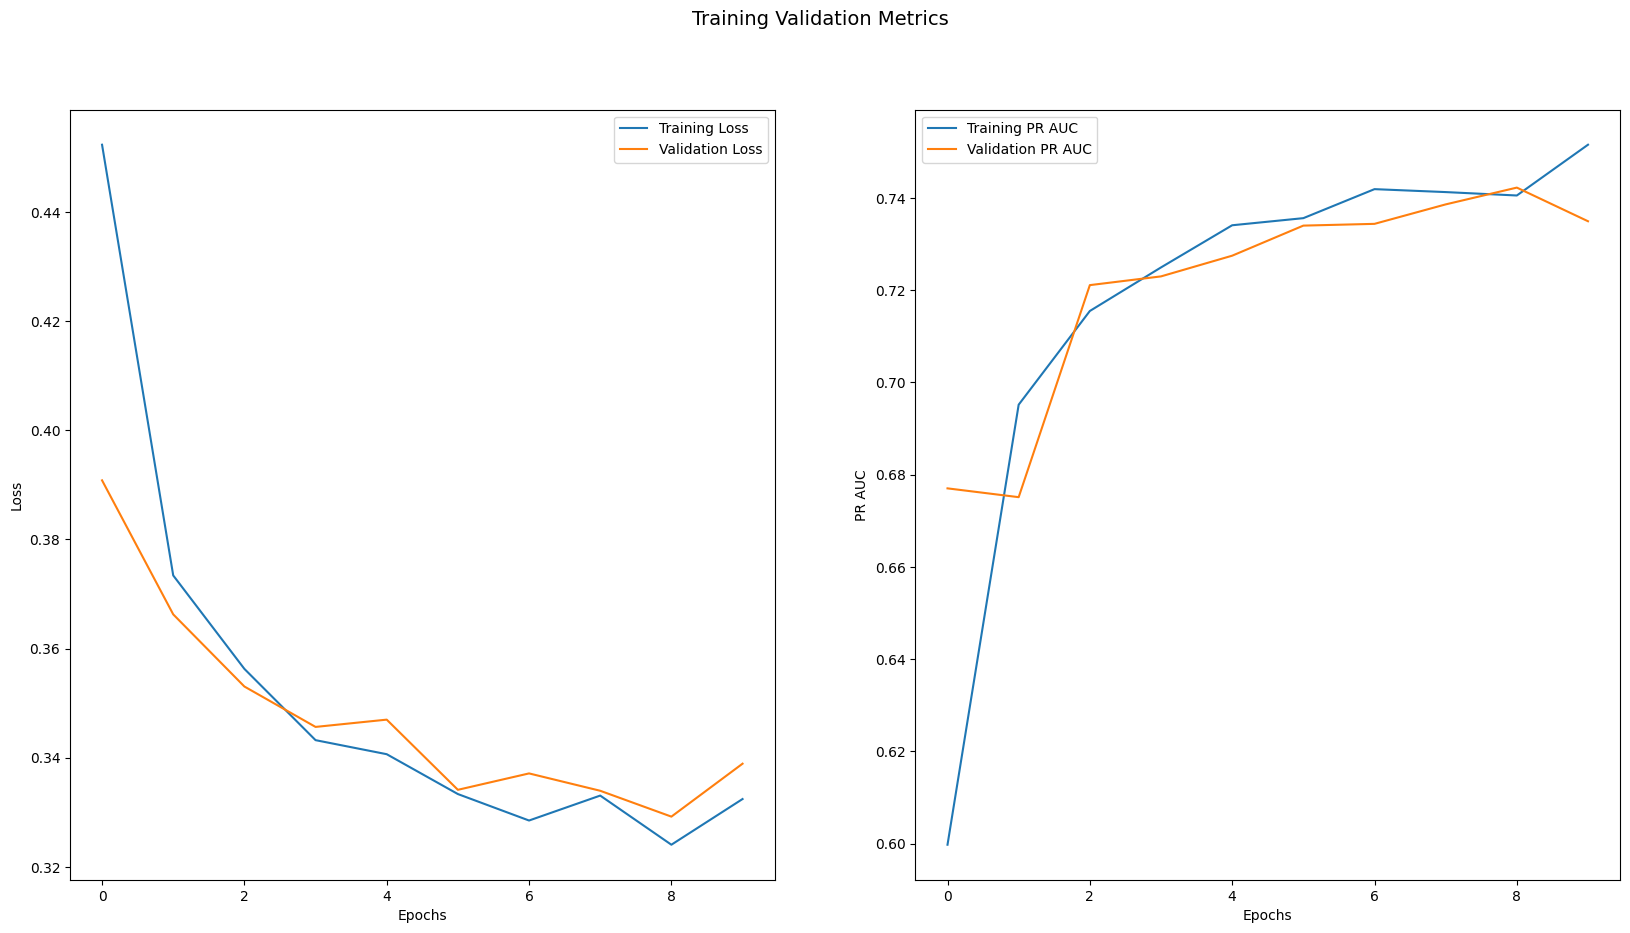

In [18]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [22]:
preds = model.predict(test_dataset)
flat_preds = preds.ravel()
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], flat_preds), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], flat_preds), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], flat_preds > 0.5), 4))

# Reported accuracy - 0.858

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


2024-03-31 10:33:01.514091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test ROC AUC: 0.9021
Test PR AUC: 0.7442
Test Accuracy: 0.8491


In [23]:
model.summary()

Model: "ft_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ ?                      │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ft_transformer_encoder          │ ?                      │       146,949 │
│ (FTTransformerEncoder)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,060 (1.69 MB)

 Trainable params: 147,686 (576.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 295,374 (1.13 MB)

In [27]:
model.save("model.keras")

In [25]:
loaded_model = keras.models.load_model("model.keras")

TypeError: <class 'sequential_ft_transformer.fttransformer.FTTransformer'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'sequential_ft_transformer.fttransformer', 'class_name': 'FTTransformer', 'config': {'name': 'ft_transformer', 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'FTTransformer', 'build_config': {'input_shape': {'cat_inputs': [1000, 1, 8], 'numeric_inputs': [1000, 1, 5]}}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'AdamW', 'config': {'name': 'adamw', 'learning_rate': 0.0010000000474974513, 'weight_decay': 0.0001, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'BinaryCrossentropy', 'config': {'name': 'binary_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'label_smoothing': 0.0, 'axis': -1}, 'registered_name': None}, 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'AUC', 'config': {'name': 'PR AUC', 'dtype': None, 'num_thresholds': 200, 'curve': 'PR', 'summation_method': 'interpolation', 'multi_label': False, 'num_labels': None, 'label_weights': None, 'from_logits': False}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'sequential_ft_transformer.fttransformer.FTTransformer'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of FTTransformer from its config.

Received config={'name': 'ft_transformer', 'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: FTTransformer.__init__() missing 3 required positional arguments: 'out_dim', 'out_activation', and 'feature_unique_counts'

## Explainability

In [ ]:
# if 'importances' in preds.keys():
#     importances = preds['importances']
#     importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
#     importances_fig, total_importances = plot_importances(
#         importances_df, 
#         title="Importances for FT-Transformer"
#     )

In [ ]:
# if 'importances' in preds.keys():
#     # Largest prediction
#     max_idx = np.argsort(preds['output'].ravel())[-1]
#     example_importance_linear = importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
#         test_data.iloc[max_idx, :].rename("Example Value")
#     ).head(5)
#     print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(preds['output'].ravel()[max_idx], 4))}")
#     display(example_importance_linear)

#     # Smallest one
#     min_idx = np.argsort(preds['output'].ravel())[0]
#     example_importance_linear = importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
#         test_data.iloc[min_idx, :].rename("Example Value")
#     ).head(5)
#     print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(preds['output'].ravel()[min_idx], 4))}")
#     display(example_importance_linear)